In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import soundfile as sf
import pandas as pd
from scipy.linalg import hankel

In [2]:
def my_fft(sig, N_fft, Fs):

    X_fft = X_fft = np.fft.fft(sig, n=N_fft)
    freqs = np.fft.fftfreq(N_fft, 1/Fs)

    # only use the positive frequencies
    half_n = N_fft // 2
    X_fft = X_fft[:half_n]
    freqs = freqs[:half_n]

    return X_fft, freqs

# get hankel matrix of x: X
def get_hankel(x, n):
    X = hankel(x[:n], x[n-1:])
    return X

# get correlation of X: R_xx
def get_correlation(X, n):
    l = x.shape[0] - n + 1
    R_xx = X @ X.transpose().conj() / l
    return R_xx

# get signal space W and Wt
def get_W(R_xx, K):
    U, _, Vh = np.linalg.svd(R_xx)
    W = U[:, :K]
    Wt = Vh[:, K:]
    return W, Wt

def get_delta_f(W):
    # get W_up and W_down from W
    W_up = W[1:, :]
    W_down = W[:-1, :]

    # compute Phi
    Phi = np.linalg.pinv(W_down) @ W_up

    # get eigenvalues of Phi
    zk,_ = np.linalg.eig(Phi)

    delta_k = np.log(np.abs(zk))
    f_k = np.angle(zk) / (2 * np.pi)

    return delta_k, f_k

def ESPRIT(x, n, K, threshold=None):
    X = get_hankel(x, n)
    R_xx = get_correlation(X, n)
    W, Wt = get_W(R_xx, K)
    delta_k, f_k = get_delta_f(W)
    # for the case of delta > 0, use a threshold instead
    if threshold != None:
        delta_k = [min(delta, threshold) for delta in delta_k]
    return delta_k, f_k

def LeastSquares(x, delta, f):
    ln_z = delta + 2j * np.pi * f
    V = np.exp(np.outer(np.arange(x.shape[0]), ln_z))
    alpha = np.linalg.pinv(V) @ x.transpose()
    a = np.abs(alpha)
    phi = np.angle(alpha)
    return a, phi

def MUSIC(x, n, K, delta_grid, f_grid):
    X = get_hankel(x, n)
    R_xx = get_correlation(X, n)
    _, Wt = get_W(R_xx, K)
    v_n_z = np.vander((np.exp(delta_grid + 2j * np.pi * f_grid)).flatten(), n, increasing=True).T 
    product = np.dot(Wt.conj().transpose(), v_n_z)
    norm_square = np.linalg.norm(product, axis=0) ** 2
    P = 1 / norm_square
    P = P.reshape(delta_grid.shape)
    return P

# timpani

## parameters configuration

In [3]:
config = {
    'data folder': 'data/timpani',
    'FFT NUM': 1024 * 2,
    'ESPRIT K': 20,
    'ESPRIT n': 1024 * 2,
    'ESPRIT l': 1024 * 20,
    'xlim': [0, 1000]
}

## load files

In [4]:
file_list = os.listdir(config['data folder'])
signals = pd.DataFrame(columns=['file_name', 'signal', 'Fs'])

for idx, file in enumerate(file_list):
    x, Fs = sf.read(os.path.join(config['data folder'], file))
    x = x[:, 0]
    signals.loc[idx] = [file, x, Fs]

## calculate frequency

-----middle_F1sharp.wav-----
[ 94.1887625  120.74437822 143.98468007 160.4106701  206.34106972
 252.21626559 268.89804431 369.17415207 382.68374021 476.66639494]
-----middle_G1sharp.wav-----
[105.3366865  121.17675638 161.36297799 181.50297249 230.48937294
 301.02748362 409.67325333 497.01646075 618.81105713 764.95647723]
-----side_F1sharp_1.wav-----
[ 93.27305815 100.41260831 141.38916653 171.73508294 200.15148569
 263.39681583 380.02972148 418.08836455 427.44732231 481.93949186]
-----side_F1sharp_2.wav-----
[ 93.14879523 126.61858179 141.58238504 164.62987846 192.19785639
 202.38447021 272.06887389 368.75792185 433.9019472  552.2153584 ]
-----side_G1sharp_1.wav-----
[104.66488382 116.40403314 159.56323452 185.16270035 227.08810539
 292.07312437 310.75521829 358.66453895 420.11646775 500.18644562]
-----side_G1sharp_2.wav-----
[104.42154646 118.23924823 159.64622981 185.67400983 221.29859265
 231.15268406 296.86766436 337.67447225 386.04344797 417.07145406]


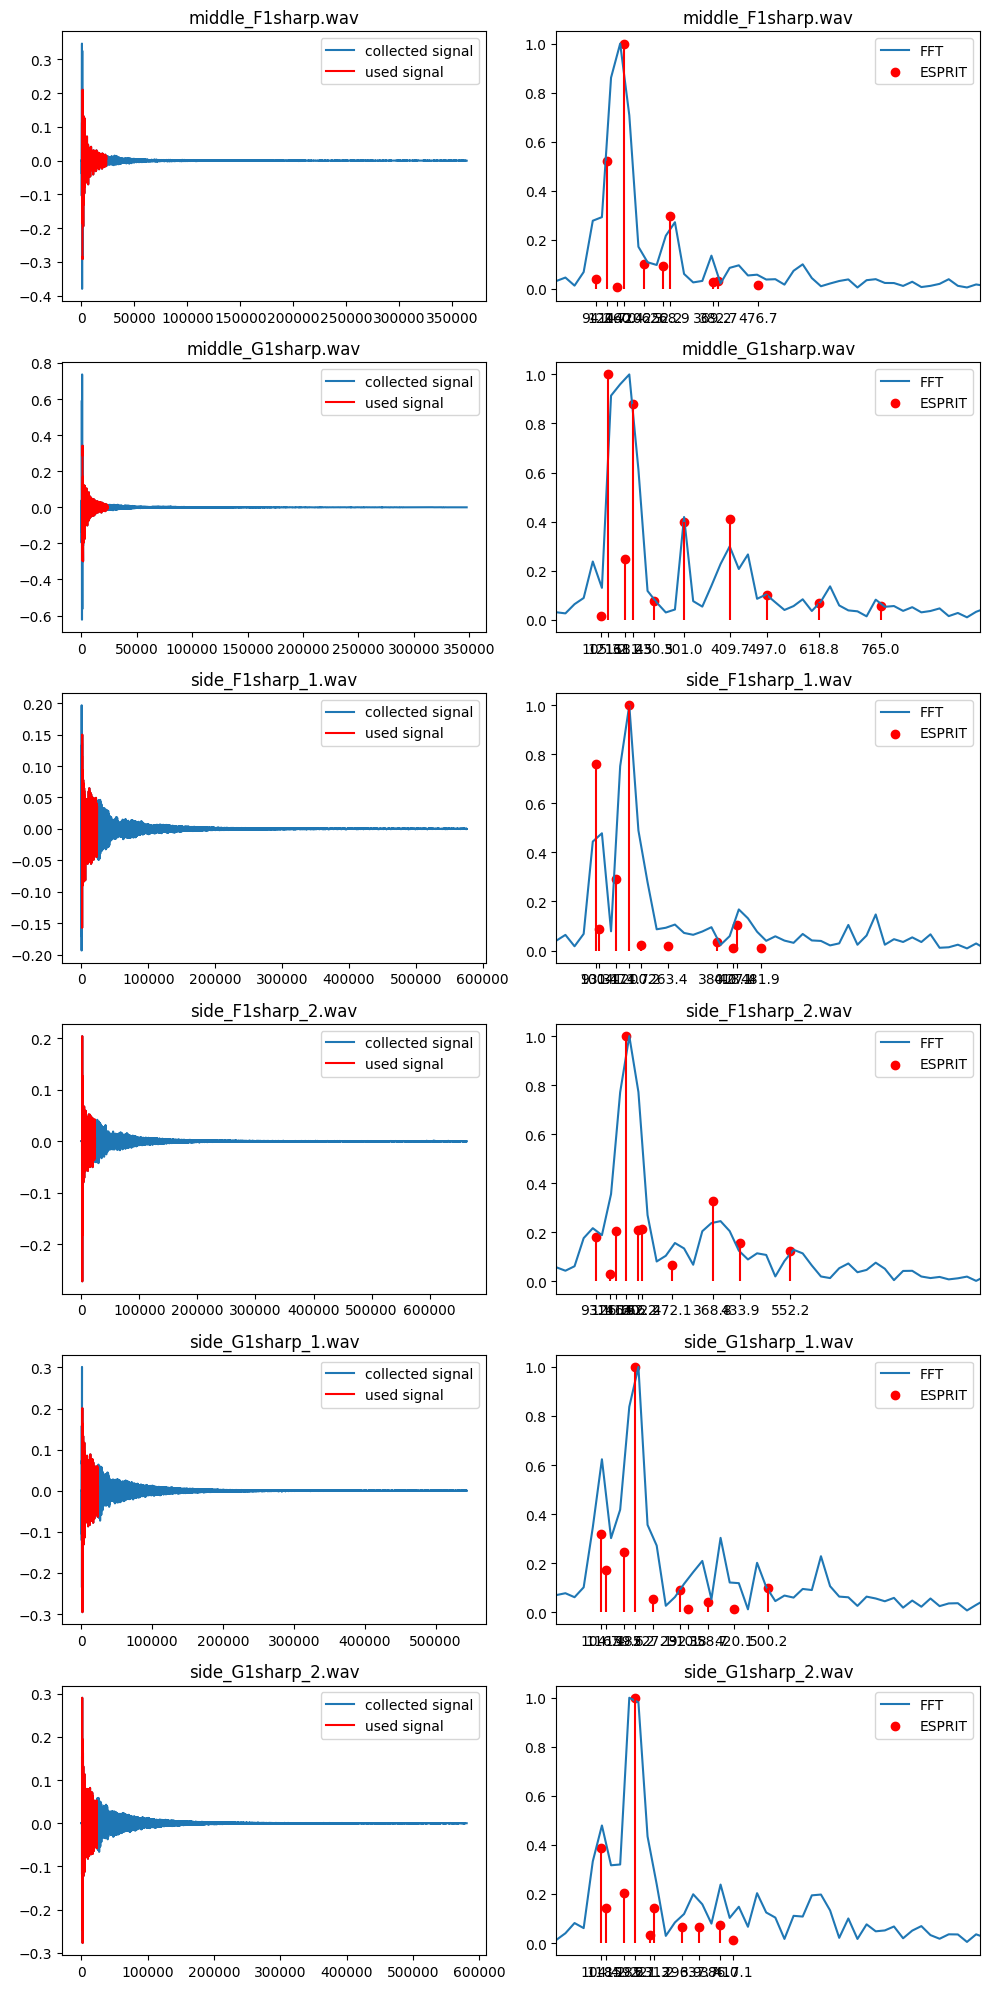

In [5]:
N_fig = len(signals)
fig, ax = plt.subplots(N_fig, 2, figsize=(10, 20))
for idx, file_name, x, Fs in signals.itertuples():

    # FFT method
    X_fft, freqs = my_fft(x, config['FFT NUM'], Fs)
    # normalize X_fft
    X_fft = X_fft / np.max(np.abs(X_fft))
    ax[idx, 0].plot(x, label='collected signal')
    ax[idx, 0].set_title(file_name)
    ax[idx, 1].plot(freqs, np.abs(X_fft), label='FFT')
    ax[idx, 1].set_title(file_name)

    # MUSIC method
    K = config['ESPRIT K']
    n = config['ESPRIT n']
    l = config['ESPRIT l']
    
    N = n + l - 1
    start = 1000
    sig = x[start: start + N]
    sig_delta, sig_f = ESPRIT(sig, n, K, threshold=-1e-5)
    sig_a, sig_phi = LeastSquares(sig, sig_delta, sig_f)
    
    # sort sig_a, sig_phi, sig_delta, sig_f by sig_f
    sig_a = sig_a[np.argsort(sig_f)]
    sig_f = np.sort(sig_f)
    # only show positive frequencies for sig_f and sig_a
    sig_f = sig_f[K//2:]
    sig_a = sig_a[K//2:]
    # normalize sig_a
    sig_a = sig_a / np.max(np.abs(sig_a))

    ax[idx, 0].plot(range(start, start + N), sig, label='used signal', color='red')
    ax[idx, 1].scatter(sig_f * Fs, sig_a, label='ESPRIT', color='red')
    ax[idx, 1].vlines(sig_f * Fs, np.zeros_like(sig_f), sig_a, color='red')
    # note frequency in x-axis
    ax[idx, 1].set_xticks(sig_f * Fs)
    ax[idx, 0].legend()
    ax[idx, 1].legend()
    ax[idx, 1].set_xlim(config['xlim'])

    print(f'-----{file_name}-----\n{sig_f * Fs}')
plt.tight_layout()
plt.show()

# glockenspiel

## parameters configuration

In [6]:
config = {
    'data folder': 'data/glockenspiel',
    'FFT NUM': 1024 * 2,
    'ESPRIT K': 20,
    'ESPRIT n': 1024 * 2,
    'ESPRIT l': 1024 * 20,
    'xlim': [0, 10000]
}

## load files

In [7]:
file_list = os.listdir(config['data folder'])
signals = pd.DataFrame(columns=['file_name', 'signal', 'Fs'])

for idx, file in enumerate(file_list):
    x, Fs = sf.read(os.path.join(config['data folder'], file))
    x = x[:, 0]
    signals.loc[idx] = [file, x, Fs]

## calculate frequency

-----F_down.wav-----
[1.39765804e+01 1.92909423e+02 3.18834319e+03 3.19001492e+03
 7.07670418e+03 7.08580867e+03 8.47610855e+03 8.53263514e+03
 1.43209448e+04 1.59389575e+04]
-----F_middle.wav-----
[9.07762417e+00 3.18962263e+03 3.19972963e+03 4.08910362e+03
 5.64281694e+03 7.08827556e+03 8.51287440e+03 8.52860040e+03
 8.53648095e+03 1.43210578e+04]
-----F_up.wav-----
[6.59691123e+00 3.17822732e+03 3.18937807e+03 3.20299117e+03
 3.92536488e+03 4.87229631e+03 5.40893083e+03 6.48979525e+03
 8.53034720e+03 1.59382825e+04]
-----G_down.wav-----
[ 1943.20208335  3330.86412982  3732.91483057  6187.17873309
  6201.11124839  6708.78854266  9868.2677876  10058.86664963
 12470.37093474 13998.00442676]
-----G_middle.wav-----
[  704.12762867  1889.84509192  1943.87982397  3736.70887378
  6168.2893138   6193.11419883  6213.20824972  6708.71996354
  9037.82781228 10059.17121307]
-----G_up.wav-----
[  704.07660462  1944.79020537  3720.06522974  3734.11866516
  6194.77862223  6708.87366553  9013.288148

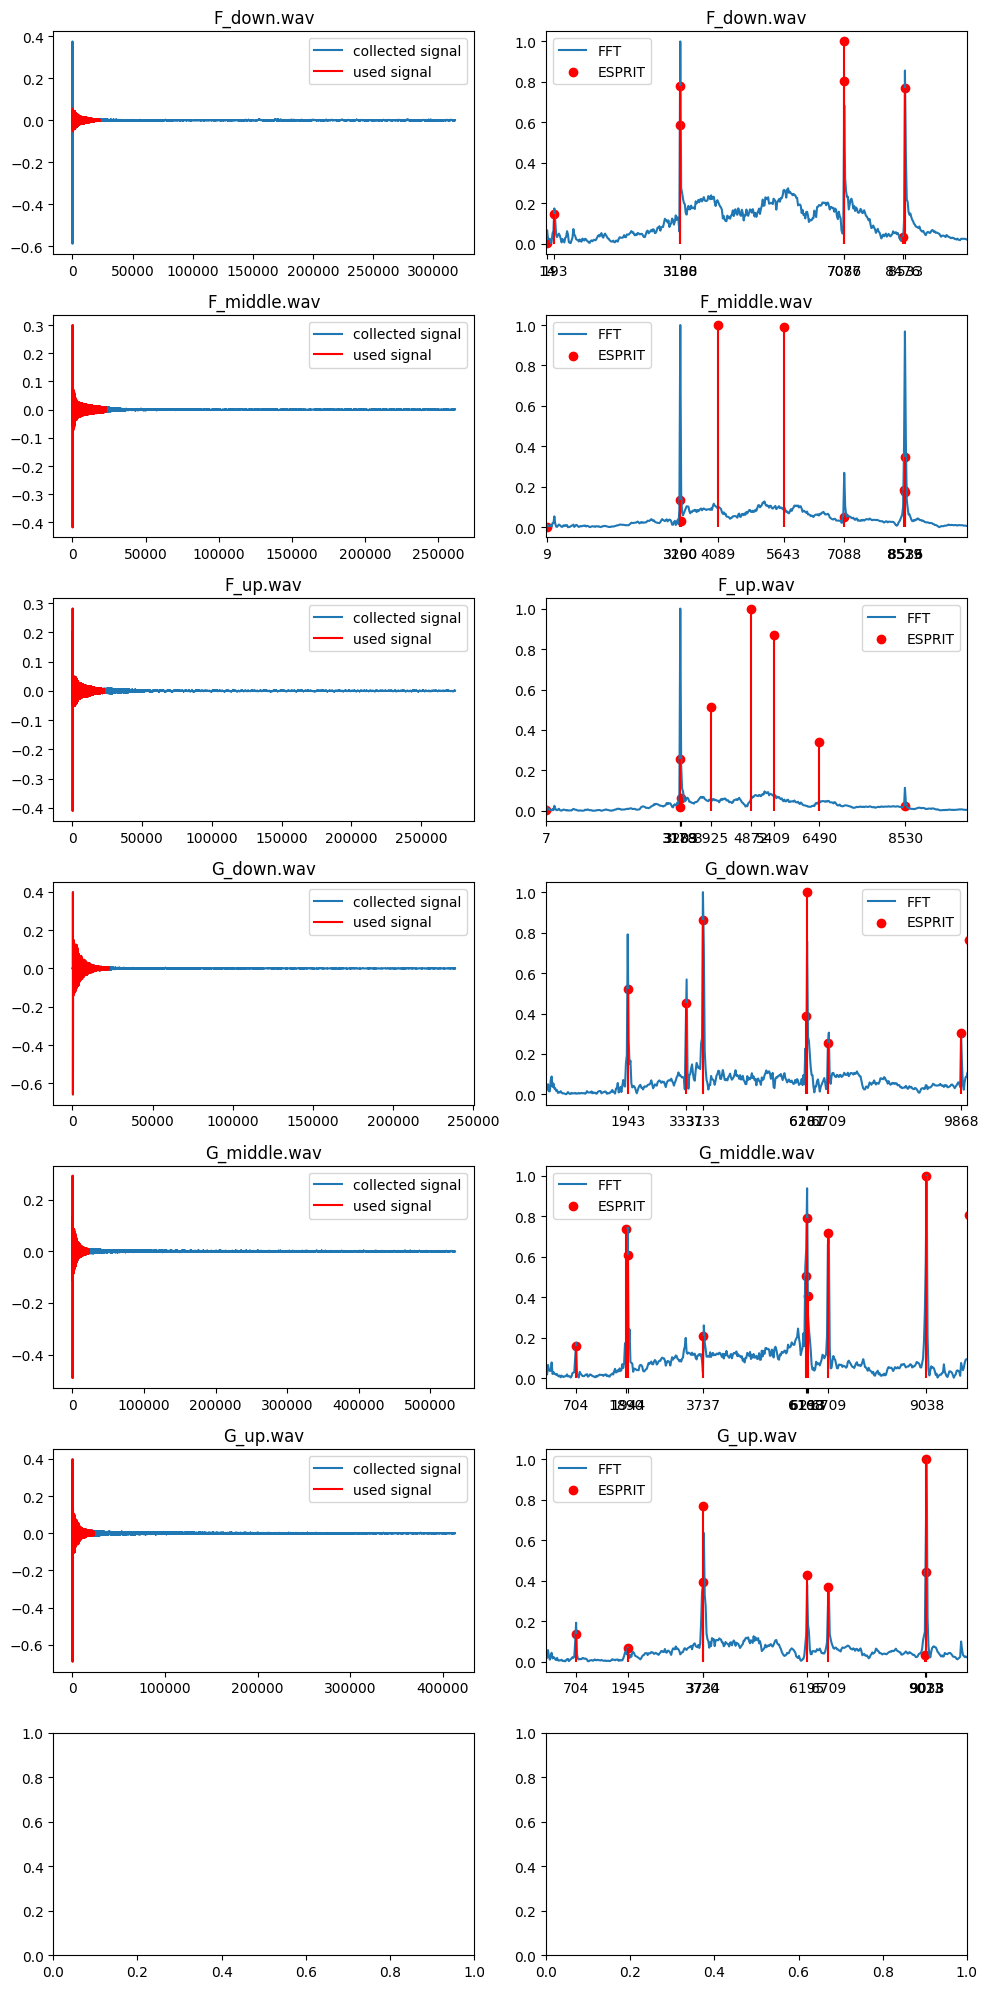

In [8]:
N_fig = len(signals)
fig, ax = plt.subplots(N_fig, 2, figsize=(10, 20))
for idx, file_name, x, Fs in signals.itertuples():
    if file_name == 'side_2_G1sharp.wav':
        continue

    # FFT method
    X_fft, freqs = my_fft(x, config['FFT NUM'], Fs)
    # normalize X_fft
    X_fft = X_fft / np.max(np.abs(X_fft))
    ax[idx, 0].plot(x, label='collected signal')
    ax[idx, 0].set_title(file_name)
    ax[idx, 1].plot(freqs, np.abs(X_fft), label='FFT')
    ax[idx, 1].set_title(file_name)

    # MUSIC method
    K = config['ESPRIT K']
    n = config['ESPRIT n']
    l = config['ESPRIT l']
    
    N = n + l - 1
    start = 100
    sig = x[start: start + N]
    sig_delta, sig_f = ESPRIT(sig, n, K, threshold=-1e-5)
    sig_a, sig_phi = LeastSquares(sig, sig_delta, sig_f)
    
    # sort sig_a, sig_phi, sig_delta, sig_f by sig_f
    sig_a = sig_a[np.argsort(sig_f)]
    sig_f = np.sort(sig_f)
    # only show positive frequencies for sig_f and sig_a
    sig_f = sig_f[K//2:]
    sig_a = sig_a[K//2:]
    # normalize sig_a
    sig_a = sig_a / np.max(np.abs(sig_a))

    ax[idx, 0].plot(range(start, start + N), sig, label='used signal', color='red')
    ax[idx, 1].scatter(sig_f * Fs, sig_a, label='ESPRIT', color='red')
    ax[idx, 1].vlines(sig_f * Fs, np.zeros_like(sig_f), sig_a, color='red')
    # note frequency in x-axis
    ax[idx, 1].set_xticks(sig_f * Fs)
    ax[idx, 0].legend()
    ax[idx, 1].legend()
    ax[idx, 1].set_xlim(config['xlim'])

    print(f'-----{file_name}-----\n{sig_f * Fs}')
plt.tight_layout()
plt.show()

# vibraphone

## parameters configuration

In [9]:
config = {
    'data folder': 'data/vibraphone',
    'FFT NUM': 1024 * 2,
    'ESPRIT K': 10,
    'ESPRIT n': 1024 * 2,
    'ESPRIT l': 1024 * 50,
    'xlim': [0, 5000]
}

## load files

In [10]:
file_list = os.listdir(config['data folder'])
signals = pd.DataFrame(columns=['file_name', 'signal', 'Fs'])

for idx, file in enumerate(file_list):
    x, Fs = sf.read(os.path.join(config['data folder'], file))
    x = x[:, 0]
    signals.loc[idx] = [file, x, Fs]

## calculate frequency

-----F_ddont_know.wav-----
[ 175.34097288  702.59056834 1874.76107884 1879.84241409 1899.68894781]
-----F_down.wav-----
[ 175.34097288  702.59056834 1874.76107884 1879.84241409 1899.68894781]
-----F_middle.wav-----
[ 171.29360174  175.6320577   702.58564793 1876.9647163  4453.68711876]
-----F_up.wav-----
[ 175.44115187 1875.77569263 1880.31237189 1902.66992817 2468.98907464]
-----G_down.wav-----
[   6.93884838  705.97155276  782.15085563  788.37978778 2367.64233717]
-----G_middle.wav-----
[ 710.30549978  779.43203976  788.31542348  798.56924143 3155.08349063]
-----G_up.wav-----
[707.52177665 722.93196238 779.39461056 788.31271986 798.12582552]
-----quiet_F_down.wav-----
[ 175.44256582  702.54685599 1874.36598139 1879.6915377  1897.47935089]
-----quiet_F_middle.wav-----
[ 172.89302278  175.80051767  702.57296194 1876.38304885 1883.93751118]
-----quiet_F_up.wav-----
[ 172.88327996  175.81460284  702.74375405 1876.05903569 1882.05239483]


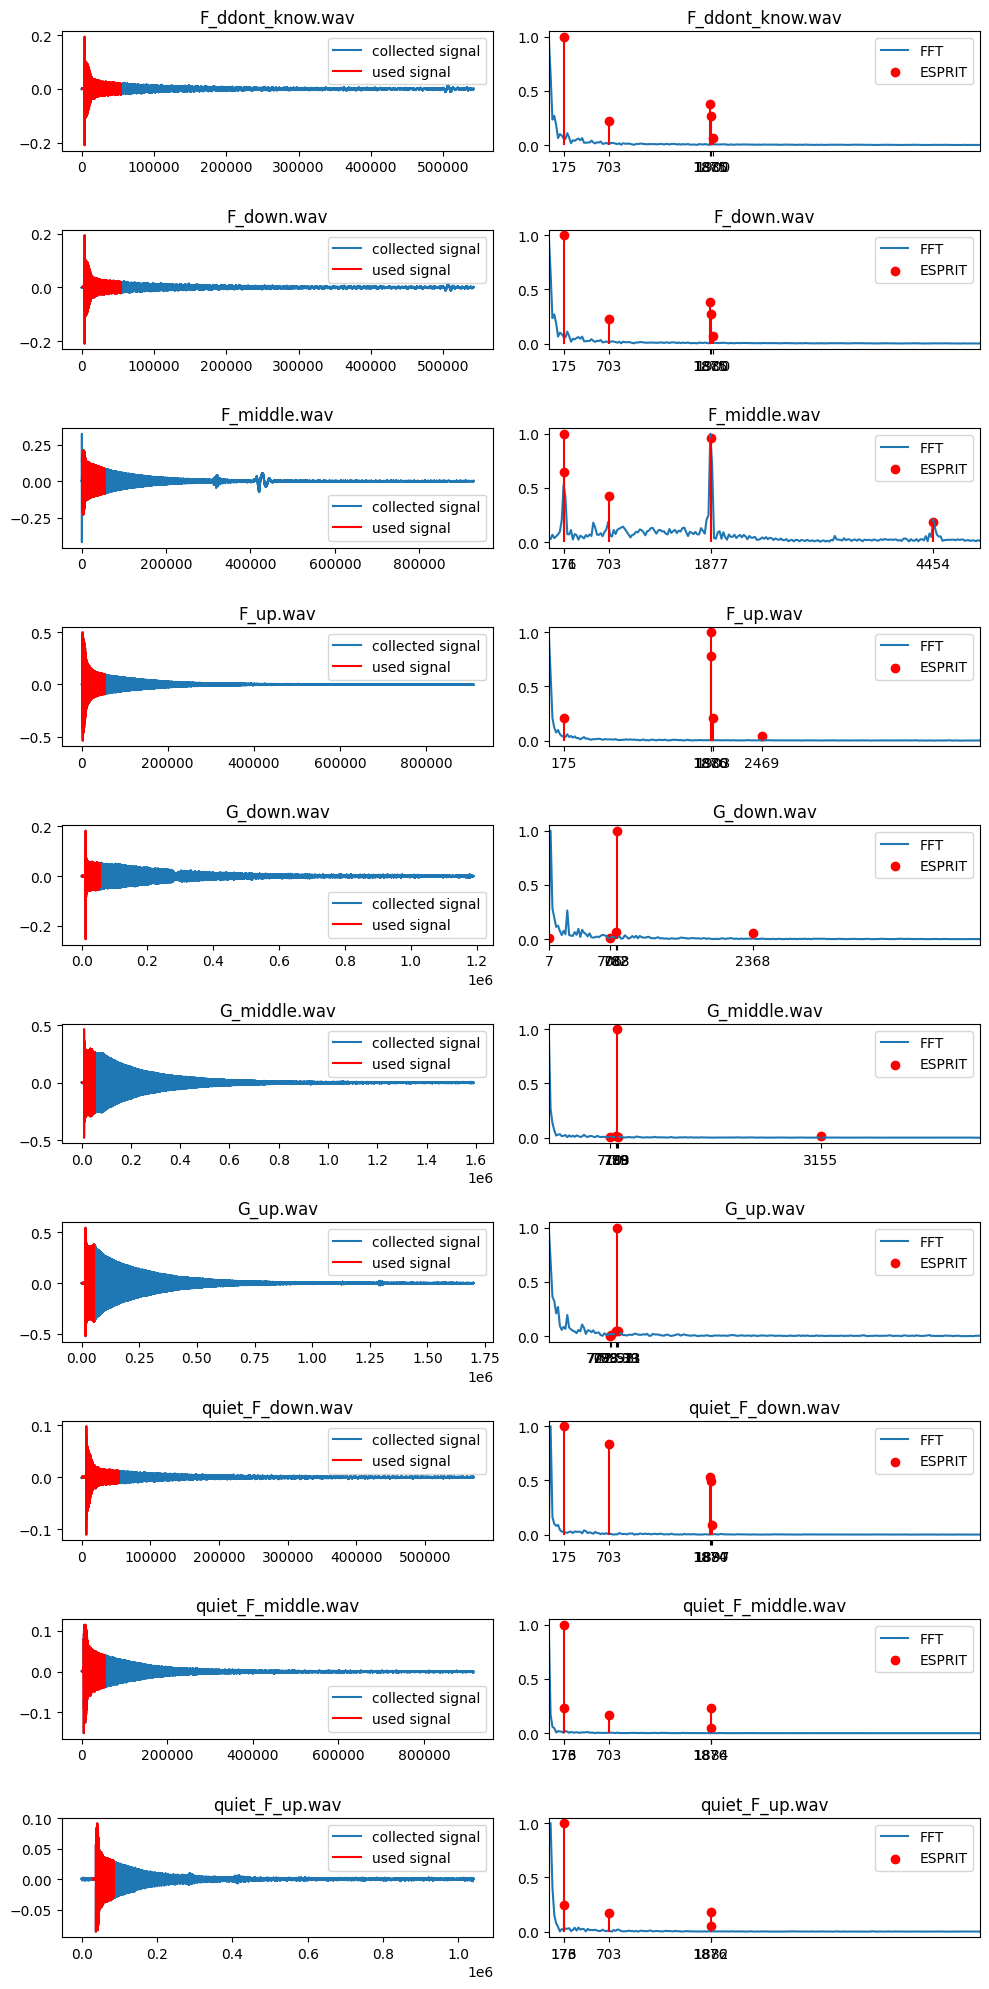

In [11]:
N_fig = len(signals)
fig, ax = plt.subplots(N_fig, 2, figsize=(10, 20))
for idx, file_name, x, Fs in signals.itertuples():

    # FFT method
    X_fft, freqs = my_fft(x, config['FFT NUM'], Fs)
    # normalize X_fft
    X_fft = X_fft / np.max(np.abs(X_fft))
    ax[idx, 0].plot(x, label='collected signal')
    ax[idx, 0].set_title(file_name)
    ax[idx, 1].plot(freqs, np.abs(X_fft), label='FFT')
    ax[idx, 1].set_title(file_name)

    # MUSIC method
    K = config['ESPRIT K']
    n = config['ESPRIT n']
    l = config['ESPRIT l']
    
    N = n + l - 1
    start = int(len(x) * 0.03) if file_name == 'quiet_F_up.wav' else 1000
    sig = x[start: start + N]
    sig_delta, sig_f = ESPRIT(sig, n, K, threshold=-1e-5)
    sig_a, sig_phi = LeastSquares(sig, sig_delta, sig_f)
    
    # sort sig_a, sig_phi, sig_delta, sig_f by sig_f
    sig_a = sig_a[np.argsort(sig_f)]
    sig_f = np.sort(sig_f)
    # only show positive frequencies for sig_f and sig_a
    sig_f = sig_f[K//2:]
    sig_a = sig_a[K//2:]
    # normalize sig_a
    sig_a = sig_a / np.max(np.abs(sig_a))

    ax[idx, 0].plot(range(start, start + N), sig, label='used signal', color='red')
    ax[idx, 1].scatter(sig_f * Fs, sig_a, label='ESPRIT', color='red')
    ax[idx, 1].vlines(sig_f * Fs, np.zeros_like(sig_f), sig_a, color='red')
    # note frequency in x-axis
    ax[idx, 1].set_xticks(sig_f * Fs)
    ax[idx, 0].legend()
    ax[idx, 1].legend()
    ax[idx, 1].set_xlim(config['xlim'])

    print(f'-----{file_name}-----\n{sig_f * Fs}')
plt.tight_layout()
plt.show()